# Predicting Amazon Review Ratings with Natural Language Processing
Note notebook left intentionally messy for showing some attempted techniques and thought processes.

# Libraries

In [1]:
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob


from joblib import Parallel, delayed
import multiprocessing

# Loading the Files

Download the csv files into the `data/` directory.

In [2]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)
                 Id  HelpfulnessNumerator  HelpfulnessDenominator  \
count  1.697533e+06          1.697533e+06            1.697533e+06   
mean   8.487660e+05          3.569048e+00            5.301422e+00   
std    4.900357e+05          1.727883e+01            2.024445e+01   
min    0.000000e+00          0.000000e+00            0.000000e+00   
25%    4.243830e+05          0.000000e+00            0.000000e+00   
50%    8.487660e+05          1.000000e+00            1.000000e+00   
75%    1.273149e+06          3.000000e+00            5.000000e+00   
max    1.697532e+06          6.084000e+03            6.510000e+03   

               Time         Score  
count  1.697533e+06  1.485341e+06  
mean   1.262422e+09  4.110517e+00  
std    1.289277e+08  1.197651e+00  
min    8.793792e+08  1.000000e+00  
25%    1.164413e+09  4.000000e+00  
50%    1.307491e+09  5.000000e+00  
75%    1.373242e+09  5.000000e+00  
max    1.406074e+09  5.000

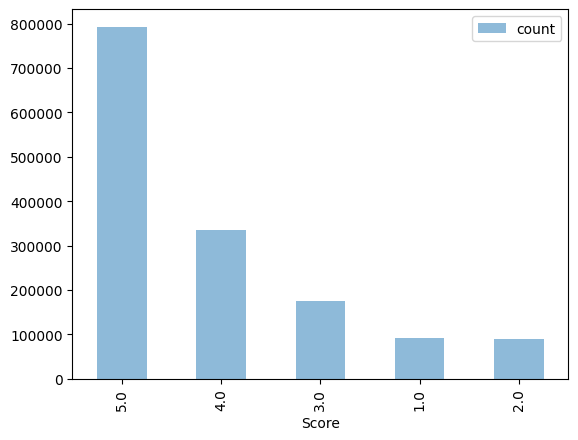


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [3]:
print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

In [4]:
# testingSet]
trainingSet.isna().sum()

Id                             0
ProductId                      0
UserId                         0
HelpfulnessNumerator           0
HelpfulnessDenominator         0
Time                           0
Summary                       32
Text                          62
Score                     212192
dtype: int64

In [5]:
trainingSet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1697533 entries, 0 to 1697532
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Id                      int64  
 1   ProductId               object 
 2   UserId                  object 
 3   HelpfulnessNumerator    int64  
 4   HelpfulnessDenominator  int64  
 5   Time                    int64  
 6   Summary                 object 
 7   Text                    object 
 8   Score                   float64
dtypes: float64(1), int64(4), object(4)
memory usage: 116.6+ MB


In [6]:
trainingSet.head(5)

,Id,ProductId,UserId,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,Score
0,914403,B0009W5KHM,AV6QDP8Q0ONK4,2,2,1341014400,GOOD FUN FILM,While most straight to DVD films are not worth...,5.0
1,354887,6303079709,A2I8RXJN80A2D2,0,0,1168819200,Movie Review,"I have wanted this one for sometime, also. I ...",5.0
2,1407653,B004H0M2XC,A3FHV3RV8Z12E6,0,0,1386201600,When is it a good time to Consent?,Actually this was a pretty darn good indie fil...,4.0
3,1377458,B003ZJ9536,A12VLTA3ZHVPUY,1,1,1348704000,TRUTH,Episodes 37 to 72 of the series press on in a ...,5.0
4,475323,630574453X,A13NM1PES9OXVN,2,3,970012800,Intelligent and bittersweet -- stays with you,"I was really impressed with this movie, but wa...",3.0


In [7]:
trainingSet[trainingSet['UserId']=='A1VZLLDNLURGJB']['Score'].value_counts()

Score
5.0    85
4.0    84
3.0    34
2.0     6
1.0     3
Name: count, dtype: int64

<Axes: xlabel='Time'>

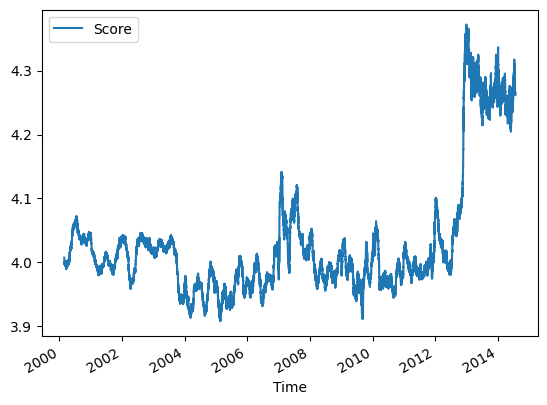

In [34]:
# sort by time and plot moving average of score
# trainingSet.sort_values(by='Time')#.plot(x='Time', y='Score', kind='line', alpha=.5)
# ma
sortedT = trainingSet.sort_values(by='Time')
# sortedT['Time'] = pd.to_datetime(sortedT['Time'])
# given in seconds
sortedT['Time'] = pd.to_datetime(sortedT['Time'], unit='s')
# drop nans
sortedT.dropna(inplace=True)
sortedT.set_index('Time', inplace=True)
sortedT['Score'].rolling(window=10000).mean().plot(legend=True)


In [9]:
# training set really big, lets take a sample for now
# trainingSet = trainingSet.sample(frac=0.01, random_state=1)

In [10]:
analyzer = SentimentIntensityAnalyzer()

# Adding Features

In [11]:
def get_vader_scores(text):
    scores = analyzer.polarity_scores(text)
    blob = TextBlob(text).sentiment
    return pd.Series([scores['compound'], scores['pos'], scores['neg'], scores['neu'], blob[0], blob[1]])

def add_features_to(df):
    # This is where you can do all your feature extraction
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    # time-based
    df['DTime'] = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = df['DTime'].dt.year
    df['Month'] = df['DTime'].dt.month
    df['Day'] = df['DTime'].dt.day
    df['DayOfWeek'] = df['DTime'].dt.dayofweek
    df['Hour'] = df['DTime'].dt.hour
    df['Minute'] = df['DTime'].dt.minute
    df['Second'] = df['DTime'].dt.second

    # vader gives: {'neg': 0.0, 'neu': 0.278, 'pos': 0.722, 'compound': 0.9326}
    if 'VaderCompText' not in df.columns:
        df['Text'] = df['Text'].astype(str)  # Ensure that the text is a string

        # Get number of cores
        num_cores = multiprocessing.cpu_count()

        # Parallelize the Vader scores computation
        results = Parallel(n_jobs=num_cores-1)(
            delayed(get_vader_scores)(text) for text in df['Text']
        )
        

        # Convert the result to a DataFrame and join with the original DataFrame
        vader_df = pd.DataFrame(results)
        vader_df.columns = ['VaderCompText', 'VaderPosText', 'VaderNegText', 'VaderNeuText', 'BlobPolarity', 'BlobSubjectivity']

        # do for summary as well
        df['Summary'] = df['Summary'].astype(str)  # Ensure that the summary is a string
        results = Parallel(n_jobs=num_cores-1)(
            delayed(get_vader_scores)(text) for text in df['Summary']
        )
        summary_vader_df = pd.DataFrame(results)
        summary_vader_df.columns = ['VaderCompSummary', 'VaderPosSummary', 'VaderNegSummary', 'VaderNeuSummary', 'BlobPolaritySummary', 'BlobSubjectivitySummary']
       
        # df = pd.concat([df, vader_df], axis=1)
        # make sure to join with index reset
        df = pd.concat([df.reset_index(drop=True), vader_df.reset_index(drop=True)], axis=1)
        df = pd.concat([df.reset_index(drop=True), summary_vader_df.reset_index(drop=True)], axis=1)
        
    

    # ALSO NEED TO DO FOR SUMMARY

    df['WordCount'] = df['Text'].apply(lambda x: len(str(x).split()))
    df['CharCount'] = df['Text'].apply(lambda x: len(str(x)))

    # See if text contains 1 star/ one star, 2 star/ two star, etc.
    df['OneStar'] = df['Text'].apply(lambda x: 1 if 'one star' in str(x).lower() or '1 star' in str(x).lower() else 0)
    df['TwoStar'] = df['Text'].apply(lambda x: 1 if 'two star' in str(x).lower() or '2 star' in str(x).lower() else 0)
    df['ThreeStar'] = df['Text'].apply(lambda x: 1 if 'three star' in str(x).lower() or '3 star' in str(x).lower() else 0)
    df['FourStar'] = df['Text'].apply(lambda x: 1 if 'four star' in str(x).lower() or '4 star' in str(x).lower() else 0)
    df['FiveStar'] = df['Text'].apply(lambda x: 1 if 'five star' in str(x).lower() or '5 star' in str(x).lower() else 0)

    # my vocabulary
    # Existing vocabulary lists
    # vocabs = {
    #     'high_vocabulary' : ['excellent', 'amazing', 'fantastic', 'wonderful', 'best', 'love', 'great', 'awesome', 'perfect', 'outstanding', 'exceptional', 'stunning'],
    #     'mid_vocabulary': ['good', 'nice', 'satisfactory', 'decent', 'fine', 'enjoy', 'like', 'prefer', 'recommend', 'solid'],
    #     'low_vocabulary' : ['bad', 'terrible', 'awful', 'worst', 'hate', 'disappoint', 'poor', 'horrible', 'not good', 'not great'],
    #     'awards_vocabulary' : ['oscar', 'golden', 'emmy'],
    #     'high_positive_vocabulary' : ['brilliant', 'superb', 'marvelous', 'spectacular', 'phenomenal', 'remarkable', 'extraordinary', 'magnificent', 'splendid', 'delightful'],
    #     'mid_positive_vocabulary' : ['pleasing', 'satisfying', 'commendable', 'admirable', 'worthy', 'agreeable', 'enjoyable', 'pleasant', 'favorable', 'gratifying'],
    #     'high_negative_vocabulary' : ['abysmal', 'dreadful', 'atrocious', 'appalling', 'horrendous', 'ghastly', 'hideous', 'abominable', 'deplorable', 'execrable'],
    #     'mid_negative_vocabulary' : ['mediocre', 'subpar', 'lackluster', 'unimpressive', 'inferior', 'unsatisfactory', 'deficient', 'inadequate', 'unremarkable', 'ordinary'],
    #     'neutral_vocabulary' : ['average', 'standard', 'typical', 'common', 'ordinary', 'regular', 'usual', 'normal', 'conventional', 'routine'],
    #     'additional_awards_vocabulary' : ['bafta', 'sundance', 'cannes', 'grammy', 'tony', 'pulitzer', 'nobel', 'booker', 'peabody', 'macarthur'],
    #     'genre_vocabulary' : ['thriller', 'comedy', 'drama', 'romance', 'horror', 'sci-fi', 'fantasy', 'documentary', 'biography', 'animation'],
    # }
    # # all vocabs for copy paste:
    # # high_vocabulary, mid_vocabulary, low_vocabulary, awards_vocabulary, high_positive_vocabulary, mid_positive_vocabulary, high_negative_vocabulary, mid_negative_vocabulary, neutral_vocabulary, additional_awards_vocabulary, genre_vocabulary
    # for key, vocab in vocabs.items():
    #     for word in vocab:
    #         df[key] = df['Text'].apply(lambda x: 1 if word in str(x).lower() else 0)


    return df

REGENERATE = False # True
RELOAD = False #True

# Load the feature extracted files if they've already been generated
if not REGENERATE and exists('./data/X_train.csv'):
    X_train = pd.read_csv("./data/X_train.csv")
if not REGENERATE and exists('./data/X_submission.csv'):
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    if RELOAD:
        trainingSet = pd.read_csv("./data/X_train.csv")
        # need to add missing ids from testing set to train for merge
        trainingSet = pd.concat([trainingSet, testingSet], ignore_index=True)

    # Process the DataFrame
    train = add_features_to(trainingSet)

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [13]:
# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train,#.drop(columns=['Score']),
    X_train['Score'],
    test_size=0.15,
    random_state=0
)
X_train. shape, X_test.shape, Y_train.shape, Y_test.shape

((1262539, 37), (222802, 37), (1262539,), (222802,))

In [14]:
# add average user score
# get X_train user average score
X_train['UserAvgScore'] = X_train.groupby('UserId')['Score'].transform('mean')
X_train['UserSDScore'] = X_train.groupby('UserId')['Score'].transform('std')
X_train['UserCount'] = X_train.groupby('UserId')['Score'].transform('count')
# then apply those UserId averages to the test set
X_test['UserAvgScore'] = X_test['UserId'].map(X_train.groupby('UserId')['Score'].mean())
X_test['UserSDScore'] = X_test['UserId'].map(X_train.groupby('UserId')['Score'].std())
X_test['UserCount'] = X_test['UserId'].map(X_train.groupby('UserId')['Score'].count())

X_submission['UserAvgScore'] = X_submission['UserId'].map(X_train.groupby('UserId')['Score'].mean())
X_submission['UserSDScore'] = X_submission['UserId'].map(X_train.groupby('UserId')['Score'].std())
X_submission['UserCount'] = X_submission['UserId'].map(X_train.groupby('UserId')['Score'].count())

# get productid descriptiive stats
X_train['ProductAvgScore'] = X_train.groupby('ProductId')['Score'].transform('mean')
X_train['ProductSDScore'] = X_train.groupby('ProductId')['Score'].transform('std')
X_train['ProductCount'] = X_train.groupby('ProductId')['Score'].transform('count')
# then apply those ProductId averages to the test set
X_test['ProductAvgScore'] = X_test['ProductId'].map(X_train.groupby('ProductId')['Score'].mean())
X_test['ProductSDScore'] = X_test['ProductId'].map(X_train.groupby('ProductId')['Score'].std())
X_test['ProductCount'] = X_test['ProductId'].map(X_train.groupby('ProductId')['Score'].count())

X_submission['ProductAvgScore'] = X_submission['ProductId'].map(X_train.groupby('ProductId')['Score'].mean())
X_submission['ProductSDScore'] = X_submission['ProductId'].map(X_train.groupby('ProductId')['Score'].std())
X_submission['ProductCount'] = X_submission['ProductId'].map(X_train.groupby('ProductId')['Score'].count())

In [15]:
# user and product descritive stats seem to work well, lets add more
X_train['UserMedianScore'] = X_train.groupby('UserId')['Score'].transform('median')
X_train['UserMaxScore'] = X_train.groupby('UserId')['Score'].transform('max')
X_train['UserMinScore'] = X_train.groupby('UserId')['Score'].transform('min')
X_train['UserScoreRange'] = X_train['UserMaxScore'] - X_train['UserMinScore']
X_train['UserScoreRange'] = X_train['UserScoreRange'].fillna(0)
# then apply those UserId averages to the test set
X_test['UserMedianScore'] = X_test['UserId'].map(X_train.groupby('UserId')['Score'].median())
X_test['UserMaxScore'] = X_test['UserId'].map(X_train.groupby('UserId')['Score'].max())
X_test['UserMinScore'] = X_test['UserId'].map(X_train.groupby('UserId')['Score'].min())
X_test['UserScoreRange'] = X_test['UserMaxScore'] - X_test['UserMinScore']
X_test['UserScoreRange'] = X_test['UserScoreRange'].fillna(0)
X_submission['UserMedianScore'] = X_submission['UserId'].map(X_train.groupby('UserId')['Score'].median())
X_submission['UserMaxScore'] = X_submission['UserId'].map(X_train.groupby('UserId')['Score'].max())
X_submission['UserMinScore'] = X_submission['UserId'].map(X_train.groupby('UserId')['Score'].min())
X_submission['UserScoreRange'] = X_submission['UserMaxScore'] - X_submission['UserMinScore']
X_submission['UserScoreRange'] = X_submission['UserScoreRange'].fillna(0)
# product
X_train['ProductMedianScore'] = X_train.groupby('ProductId')['Score'].transform('median')
X_train['ProductMaxScore'] = X_train.groupby('ProductId')['Score'].transform('max')
X_train['ProductMinScore'] = X_train.groupby('ProductId')['Score'].transform('min')
X_train['ProductScoreRange'] = X_train['ProductMaxScore'] - X_train['ProductMinScore']
X_train['ProductScoreRange'] = X_train['ProductScoreRange'].fillna(0)
# then apply those ProductId averages to the test set
X_test['ProductMedianScore'] = X_test['ProductId'].map(X_train.groupby('ProductId')['Score'].median())
X_test['ProductMaxScore'] = X_test['ProductId'].map(X_train.groupby('ProductId')['Score'].max())
X_test['ProductMinScore'] = X_test['ProductId'].map(X_train.groupby('ProductId')['Score'].min())
X_test['ProductScoreRange'] = X_test['ProductMaxScore'] - X_test['ProductMinScore']
X_test['ProductScoreRange'] = X_test['ProductScoreRange'].fillna(0)
X_submission['ProductMedianScore'] = X_submission['ProductId'].map(X_train.groupby('ProductId')['Score'].median())
X_submission['ProductMaxScore'] = X_submission['ProductId'].map(X_train.groupby('ProductId')['Score'].max())
X_submission['ProductMinScore'] = X_submission['ProductId'].map(X_train.groupby('ProductId')['Score'].min())
X_submission['ProductScoreRange'] = X_submission['ProductMaxScore'] - X_submission['ProductMinScore']
X_submission['ProductScoreRange'] = X_submission['ProductScoreRange'].fillna(0)


In [16]:
# helpfullness numerator, denominator descriptive stats
X_train['HelpfulnessAvg'] = X_train.groupby('UserId')['HelpfulnessNumerator'].transform('mean')
X_train['HelpfulnessSD'] = X_train.groupby('UserId')['HelpfulnessNumerator'].transform('std')
X_train['HelpfulnessCount'] = X_train.groupby('UserId')['HelpfulnessNumerator'].transform('count')
X_train['HelpfulnessAvgDenom'] = X_train.groupby('UserId')['HelpfulnessDenominator'].transform('mean')
X_train['HelpfulnessSDDenom'] = X_train.groupby('UserId')['HelpfulnessDenominator'].transform('std')
X_train['HelpfulnessCountDenom'] = X_train.groupby('UserId')['HelpfulnessDenominator'].transform('count')
# then apply those UserId averages to the test set
X_test['HelpfulnessAvg'] = X_test['UserId'].map(X_train.groupby('UserId')['HelpfulnessNumerator'].mean())
X_test['HelpfulnessSD'] = X_test['UserId'].map(X_train.groupby('UserId')['HelpfulnessNumerator'].std())
X_test['HelpfulnessCount'] = X_test['UserId'].map(X_train.groupby('UserId')['HelpfulnessNumerator'].count())
X_test['HelpfulnessAvgDenom'] = X_test['UserId'].map(X_train.groupby('UserId')['HelpfulnessDenominator'].mean())
X_test['HelpfulnessSDDenom'] = X_test['UserId'].map(X_train.groupby('UserId')['HelpfulnessDenominator'].std())
X_test['HelpfulnessCountDenom'] = X_test['UserId'].map(X_train.groupby('UserId')['HelpfulnessDenominator'].count())
X_submission['HelpfulnessAvg'] = X_submission['UserId'].map(X_train.groupby('UserId')['HelpfulnessNumerator'].mean())
X_submission['HelpfulnessSD'] = X_submission['UserId'].map(X_train.groupby('UserId')['HelpfulnessNumerator'].std())
X_submission['HelpfulnessCount'] = X_submission['UserId'].map(X_train.groupby('UserId')['HelpfulnessNumerator'].count())
X_submission['HelpfulnessAvgDenom'] = X_submission['UserId'].map(X_train.groupby('UserId')['HelpfulnessDenominator'].mean())
X_submission['HelpfulnessSDDenom'] = X_submission['UserId'].map(X_train.groupby('UserId')['HelpfulnessDenominator'].std())
X_submission['HelpfulnessCountDenom'] = X_submission['UserId'].map(X_train.groupby('UserId')['HelpfulnessDenominator'].count())


In [17]:
# generate int for UserId and ProductId, same for all sets
# Concatenate all datasets temporarily to ensure consistent encoding
combined = pd.concat([X_train, X_test, X_submission], keys=['train', 'test', 'submission'])

# Generate consistent integer codes for UserId and ProductId across all sets
combined['UserIdInt'] = combined['UserId'].astype('category').cat.codes
combined['ProductIdInt'] = combined['ProductId'].astype('category').cat.codes

# Separate them back
X_train['UserIdInt'] = combined.loc['train', 'UserIdInt'].values
X_test['UserIdInt'] = combined.loc['test', 'UserIdInt'].values
X_submission['UserIdInt'] = combined.loc['submission', 'UserIdInt'].values

X_train['ProductIdInt'] = combined.loc['train', 'ProductIdInt'].values
X_test['ProductIdInt'] = combined.loc['test', 'ProductIdInt'].values
X_submission['ProductIdInt'] = combined.loc['submission', 'ProductIdInt'].values



In [18]:
# lets do some tfidf and lsa
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

# first fill nans with empty string
X_train['Text'] = X_train['Text'].fillna('')
X_test['Text'] = X_test['Text'].fillna('')
X_submission['Text'] = X_submission['Text'].fillna('')

tfidf = TfidfVectorizer(max_features=300,ngram_range=(1,2), stop_words='english')
tfidf.fit(X_train['Text'])



TfidfVectorizer(max_features=300, ngram_range=(1, 2), stop_words='english')

In [19]:
X_train_tfidf = tfidf.transform(X_train['Text'])
X_test_tfidf = tfidf.transform(X_test['Text'])
X_submission_tfidf = tfidf.transform(X_submission['Text'])


In [20]:
# add tfiidf to the dataframes
X_train_tfidf_all = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names_out())
X_test_tfidf_all = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf.get_feature_names_out())
X_submission_tfidf_all = pd.DataFrame(X_submission_tfidf.toarray(), columns=tfidf.get_feature_names_out())
X_train = pd.concat([X_train.reset_index(drop=True), X_train_tfidf_all.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_tfidf_all.reset_index(drop=True)], axis=1)
X_submission = pd.concat([X_submission.reset_index(drop=True), X_submission_tfidf_all.reset_index(drop=True)], axis=1)
# feature names to add later:
tfidf_feature_names = tfidf.get_feature_names_out()
tfidf_feature_names

array(['10', '34', 'able', 'acting', 'action', 'actor', 'actors',
       'actually', 'amazing', 'amazon', 'american', 'audience', 'away',
       'bad', 'based', 'beautiful', 'beginning', 'believe', 'best',
       'better', 'big', 'bit', 'black', 'blu', 'blu ray', 'book',
       'bought', 'boy', 'buy', 'came', 'case', 'cast', 'certainly',
       'character', 'characters', 'children', 'classic', 'collection',
       'come', 'comedy', 'comes', 'completely', 'couple', 'course',
       'dark', 'daughter', 'day', 'days', 'dead', 'death', 'definitely',
       'dialogue', 'did', 'didn', 'different', 'director', 'disc', 'does',
       'doesn', 'doing', 'don', 'drama', 'dvd', 'early', 'effects', 'end',
       'ending', 'english', 'enjoy', 'enjoyed', 'entertaining', 'entire',
       'episode', 'episodes', 'especially', 'evil', 'excellent', 'extras',
       'face', 'fact', 'family', 'fan', 'fans', 'far', 'father',
       'favorite', 'features', 'feel', 'felt', 'fight', 'film', 'films',
       'fin

In [21]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

# Apply LDA for supervised dimensionality reduction
lda = LDA(n_components=min(5, len(set(Y_train)) - 1))  # Choose based on the number of classes
X_train_lda = lda.fit_transform(X_train_tfidf.toarray(), Y_train)
X_test_lda = lda.transform(X_test_tfidf.toarray())
X_submission_lda = lda.transform(tfidf.transform(X_submission['Text']).toarray())

In [22]:
# name columns
X_train_lda = pd.DataFrame(X_train_lda, columns=[f'LDA_{i}' for i in range(X_train_lda.shape[1])])
X_test_lda = pd.DataFrame(X_test_lda, columns=[f'LDA_{i}' for i in range(X_test_lda.shape[1])])
X_submission_lda = pd.DataFrame(X_submission_lda, columns=[f'LDA_{i}' for i in range(X_submission_lda.shape[1])])

# concatenate with original data
X_train = pd.concat([X_train.reset_index(drop=True), X_train_lda.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_lda.reset_index(drop=True)], axis=1)
X_submission = pd.concat([X_submission.reset_index(drop=True), X_submission_lda.reset_index(drop=True)], axis=1)

In [23]:
X_train_lda.columns

Index(['LDA_0', 'LDA_1', 'LDA_2', 'LDA_3'], dtype='object')

In [24]:
# user average ldas values for LDA_0, LDA_1, LDA_2, LDA_3
for i in range(4):
    X_train[f'UserAvgLDA_{i}'] = X_train.groupby('UserId')[f'LDA_{i}'].transform('mean')
    X_test[f'UserAvgLDA_{i}'] = X_test['UserId'].map(X_train.groupby('UserId')[f'LDA_{i}'].mean())
    X_submission[f'UserAvgLDA_{i}'] = X_submission['UserId'].map(X_train.groupby('UserId')[f'LDA_{i}'].mean())


In [25]:
# lsa
lsa = TruncatedSVD(n_components=20)
lsa.fit(X_train_tfidf)
X_train_lsa = lsa.transform(X_train_tfidf)
X_test_lsa = lsa.transform(X_test_tfidf)
X_submission_lsa = lsa.transform(X_submission_tfidf)
# convert to dataframe
X_train_lsa = pd.DataFrame(X_train_lsa)
X_test_lsa = pd.DataFrame(X_test_lsa)
X_submission_lsa = pd.DataFrame(X_submission_lsa)
# rename columns
X_train_lsa.columns = ['LSA_' + str(i) for i in range(X_train_lsa.shape[1])]
X_test_lsa.columns = ['LSA_' + str(i) for i in range(X_test_lsa.shape[1])]
X_submission_lsa.columns = ['LSA_' + str(i) for i in range(X_submission_lsa.shape[1])]
X_train_lsa

,LSA_0,LSA_1,LSA_2,LSA_3,LSA_4,LSA_5,LSA_6,LSA_7,LSA_8,LSA_9,LSA_10,LSA_11,LSA_12,LSA_13,LSA_14,LSA_15,LSA_16,LSA_17,LSA_18,LSA_19
0,0.278829,0.134858,0.011987,0.010264,-0.052211,0.166071,-0.016609,0.022367,-0.044651,0.130178,0.052306,-0.060374,0.001299,0.039726,-0.029213,-0.105301,-0.011225,-0.019292,0.075976,-0.017579
1,0.074321,-0.039688,0.257741,0.017714,-0.001879,-0.065852,-0.116862,0.031669,-0.104925,-0.069189,0.272634,0.346564,-0.065144,-0.131292,0.003343,0.012964,-0.014018,-0.002562,0.007307,-0.066303
2,0.107558,0.026820,0.095277,0.010789,-0.062902,0.210711,0.015945,0.048205,-0.036439,0.077327,-0.016793,-0.030335,-0.012142,-0.023027,-0.011140,-0.062422,-0.004173,-0.010095,-0.074477,-0.022424
3,0.293186,0.194453,0.113022,0.005204,-0.173393,0.641386,-0.148799,0.273420,-0.148840,0.281156,-0.117133,-0.011811,0.007260,-0.053180,0.026959,0.059841,-0.052776,-0.051005,0.045244,-0.027312
4,0.205842,-0.043806,0.182827,0.014393,-0.012559,-0.081223,0.010749,-0.001094,-0.091388,-0.018197,-0.066049,-0.131865,0.100297,0.004082,0.016931,0.079413,-0.051958,0.078287,-0.032837,0.102838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1262534,0.283229,-0.400853,-0.271515,0.421078,0.159790,0.143188,-0.048780,0.014324,-0.050016,-0.167025,0.155149,-0.092446,0.024726,-0.000508,-0.002991,0.063113,-0.004192,0.010260,0.001889,0.030372
1262535,0.157254,-0.029101,0.056772,-0.009154,0.000970,-0.042260,-0.065859,-0.002170,0.017848,0.027742,-0.107727,0.049645,-0.012666,0.090078,0.030221,0.008666,0.040456,-0.014565,-0.039828,0.027362
1262536,0.219477,0.015696,0.062928,0.005175,-0.032243,0.087053,0.023412,-0.011003,0.020000,0.197451,0.071281,-0.040969,0.135882,0.033329,-0.054632,-0.010652,0.029832,-0.096732,-0.015464,-0.129027
1262537,0.504837,-0.157342,0.062553,-0.002056,-0.086215,0.126722,0.217936,0.004536,0.022809,-0.081011,0.054161,0.119432,0.057956,0.089723,-0.180545,0.082253,-0.053129,0.042812,0.005033,-0.162004


In [26]:
# concat with original data
X_train = pd.concat([X_train.reset_index(drop=True), X_train_lsa.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), X_test_lsa.reset_index(drop=True)], axis=1)
X_submission = pd.concat([X_submission.reset_index(drop=True), X_submission_lsa.reset_index(drop=True)], axis=1)

In [27]:
# defragment the dataframes with copy
X_train = X_train.copy()
X_test = X_test.copy()
X_submission = X_submission.copy()


# Feature Selection

In [28]:
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time','Year','Month','Day','DayOfWeek','Hour','Minute','Second', 'Helpfulness', 'VaderCompText', 'VaderPosText', 'VaderNegText', 'VaderNeuText','UserAvgScore']
features = ['HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time','Year','Month','Day','DayOfWeek','Hour','Minute','Second', 'Helpfulness', 'VaderCompText', 'VaderPosText', 'VaderNegText', 'VaderNeuText', 'BlobPolarity', 'BlobSubjectivity', 'WordCount', 'CharCount']
features += ['UserAvgScore','UserSDScore','UserCount', 'OneStar', 'TwoStar', 'ThreeStar', 'FourStar', 'FiveStar', 'ProductAvgScore', 'ProductSDScore', 'ProductCount']
features += ['VaderCompSummary', 'VaderPosSummary', 'VaderNegSummary', 'VaderNeuSummary', 'BlobPolaritySummary', 'BlobSubjectivitySummary']
features +=  ['LSA_' + str(i) for i in range(20)]
features += ['LDA_' + str(i) for i in range(4)]
# features += ['high_vocabulary', 'mid_vocabulary', 'low_vocabulary', 'awards_vocabulary', 'high_positive_vocabulary', 'mid_positive_vocabulary', 'high_negative_vocabulary', 'mid_negative_vocabulary', 'neutral_vocabulary', 'additional_awards_vocabulary', 'genre_vocabulary']
features += ['UserMedianScore', 'UserMaxScore', 'UserMinScore', 'UserScoreRange', 'ProductMedianScore', 'ProductMaxScore', 'ProductMinScore', 'ProductScoreRange']
features += ['UserAvgLDA_' + str(i) for i in range(4)]
features += ['HelpfulnessAvg', 'HelpfulnessSD', 'HelpfulnessCount', 'HelpfulnessAvgDenom', 'HelpfulnessSDDenom', 'HelpfulnessCountDenom']
# features += ['UserIdInt', 'ProductIdInt']
# features = top_features
features += tfidf_feature_names.tolist()
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

In [30]:
# drop duplicate columns (if any)
X_train_select = X_train_select.loc[:,~X_train_select.columns.duplicated()]
X_test_select = X_test_select.loc[:,~X_test_select.columns.duplicated()]
X_submission_select = X_submission_select.loc[:,~X_submission_select.columns.duplicated()]
X_train_select.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Time,Year,Month,Day,DayOfWeek,Hour,Minute,Second,...,work,works,world,worth,written,wrong,year,years,yes,young
0,0,1,1206662400,2008,3,28,4,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,9,1265155200,2010,2,3,2,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,1386201600,2013,12,5,3,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,1395619200,2014,3,24,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1,1262304000,2010,1,1,4,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Creation

In [31]:
# Learn the model
# model = KNeighborsClassifier(n_neighbors=3).fit(X_train_select, Y_train)
# model = lgb.LGBMClassifier().fit(X_train_select, Y_train)  # LightGBM model
# build lgb model
model = lgb.LGBMClassifier(objective='multiclass', num_class=5, metric='multi_logloss',num_iterations=300,random_state=0, n_jobs=-1)
model.fit(X_train_select, Y_train)

# Predict the score using the model
Y_test_predictions = model.predict(X_test_select)
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

c:\Users\rjgil\Desktop\cs506\midterm\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.757705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 91316
[LightGBM] [Info] Number of data points in the train set: 1262539, number of used features: 375
[LightGBM] [Info] Start training from score -2.791803
[LightGBM] [Info] Start training from score -2.808372
[LightGBM] [Info] Start training from score -2.132928
[LightGBM] [Info] Start training from score -1.488254
[LightGBM] [Info] Start training from score -0.627116
Accuracy on testing set =  0.6551512104918268


In [111]:
# # create bagging ensemble
# from sklearn.ensemble import BaggingClassifier

# bagging_model = BaggingClassifier(estimator=model, n_estimators=10, random_state=0)
# bagging_model.fit(X_train_select, Y_train)
# Y_test_bagging_predictions = bagging_model.predict(X_test_select)
# # Evaluate the model
# accuracy = accuracy_score(Y_test, Y_test_bagging_predictions)

c:\Users\rjgil\Desktop\cs506\midterm\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\rjgil\Desktop\cs506\midterm\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\rjgil\Desktop\cs506\midterm\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\rjgil\Desktop\cs506\midterm\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\rjgil\Desktop\cs506\mid

# Model Evaluation

Accuracy on testing set =  0.6551512104918268


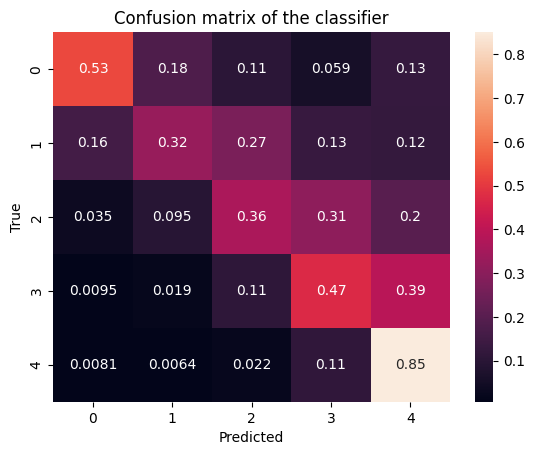

In [32]:
# Evaluate your model on the testing set
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

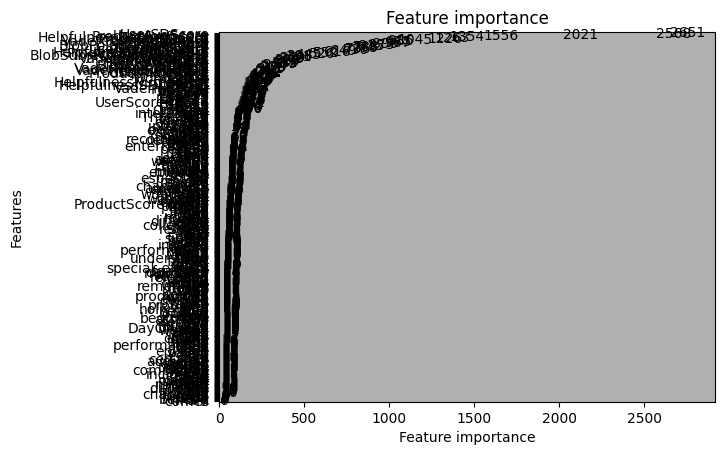

In [33]:
# get feature importances, note this looks better at the start of modelling, when I had less features...
lgb.plot_importance(model)

In [34]:
# print feature importances
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
for i in range(len(feature_importances)):
    print(feature_importances.iloc[i, 0], feature_importances.iloc[i, 1])

UserSDScore 2651
UserAvgScore 2568
ProductAvgScore 2021
HelpfulnessDenominator 1556
UserCount 1354
ProductSDScore 1263
UserAvgLDA_0 1226
VaderCompSummary 1045
Helpfulness 986
Time 975
ProductCount 967
BlobPolaritySummary 899
LDA_0 873
UserAvgLDA_1 815
UserMinScore 788
UserMedianScore 778
BlobPolarity 736
LDA_1 730
HelpfulnessAvgDenom 649
ProductMedianScore 616
ProductMinScore 552
BlobSubjectivitySummary 526
VaderCompText 445
LDA_2 398
VaderPosSummary 391
VaderPosText 359
UserMaxScore 349
VaderNegText 328
LSA_6 327
HelpfulnessAvg 320
UserAvgLDA_3 312
LSA_2 309
BlobSubjectivity 257
CharCount 244
LDA_3 239
VaderNegSummary 239
bad 221
VaderNeuSummary 217
ProductMaxScore 212
HelpfulnessSD 212
UserAvgLDA_2 212
LSA_7 192
horror 186
good 178
WordCount 170
LSA_4 170
LSA_8 168
FiveStar 165
best 159
HelpfulnessNumerator 156
LSA_18 145
better 145
LSA_0 142
HelpfulnessSDDenom 142
LSA_15 141
VaderNeuText 139
FourStar 137
original 134
TwoStar 129
people 126
highly 124
evil 124
LSA_3 123
LSA_13 122
re

In [35]:
# top 80% of features
threshold = feature_importances['Importance'].quantile(0.1)
top_features = feature_importances[feature_importances['Importance'] >= threshold]['Feature'].tolist()
print("Top features: ", top_features)

Top features:  ['UserSDScore', 'UserAvgScore', 'ProductAvgScore', 'HelpfulnessDenominator', 'UserCount', 'ProductSDScore', 'UserAvgLDA_0', 'VaderCompSummary', 'Helpfulness', 'Time', 'ProductCount', 'BlobPolaritySummary', 'LDA_0', 'UserAvgLDA_1', 'UserMinScore', 'UserMedianScore', 'BlobPolarity', 'LDA_1', 'HelpfulnessAvgDenom', 'ProductMedianScore', 'ProductMinScore', 'BlobSubjectivitySummary', 'VaderCompText', 'LDA_2', 'VaderPosSummary', 'VaderPosText', 'UserMaxScore', 'VaderNegText', 'LSA_6', 'HelpfulnessAvg', 'UserAvgLDA_3', 'LSA_2', 'BlobSubjectivity', 'CharCount', 'LDA_3', 'VaderNegSummary', 'bad', 'VaderNeuSummary', 'ProductMaxScore', 'HelpfulnessSD', 'UserAvgLDA_2', 'LSA_7', 'horror', 'good', 'WordCount', 'LSA_4', 'LSA_8', 'FiveStar', 'best', 'HelpfulnessNumerator', 'LSA_18', 'better', 'LSA_0', 'HelpfulnessSDDenom', 'LSA_15', 'VaderNeuText', 'FourStar', 'original', 'TwoStar', 'people', 'highly', 'evil', 'LSA_3', 'LSA_13', 'reviews', 'LSA_19', 'LSA_17', 'LSA_1', 'stars', 'UserScor

# Create submission file

In [36]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)

In [37]:
# auto ml
from flaml import AutoML
automl = AutoML()
automl.fit(X_train_select, Y_train, task="classification", time_budget=600)
Y_test_predictions = automl.predict(X_test_select)
print("AutoML Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))

[flaml.automl.logger: 10-28 10:51:38] {1728} INFO - task = classification
[flaml.automl.logger: 10-28 10:51:38] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 10-28 10:51:51] {1838} INFO - Minimizing error metric: log_loss
[flaml.automl.logger: 10-28 10:51:51] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd', 'lrl1']
[flaml.automl.logger: 10-28 10:51:51] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 10-28 10:51:52] {2393} INFO - Estimated sufficient time budget=809771s. Estimated necessary time budget=18746s.
[flaml.automl.logger: 10-28 10:51:52] {2442} INFO -  at 121.5s,	estimator lgbm's best error=1.0879,	best estimator lgbm's best error=1.0879
[flaml.automl.logger: 10-28 10:51:52] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 10-28 10:51:52] {2442} INFO -  at 122.0s,	estimator lgbm's best error=1.0879,	best estimator lgbm's best error=1.0879
[flaml.automl.l

In [38]:
# use automl for submission
X_submission['Score'] = automl.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]

submission.to_csv("./data/submission_automl.csv", index=False)

In [39]:
# lets train a model for each class (binary outcome) then a final model to combine them
five_star_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss',num_iterations=300,random_state=0, n_jobs=-1)
five_star_model.fit(X_train_select, (Y_train == 5).astype(int))
four_star_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss',num_iterations=300,random_state=0, n_jobs=-1)
four_star_model.fit(X_train_select, (Y_train == 4).astype(int))
three_star_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss',num_iterations=300,random_state=0, n_jobs=-1)
three_star_model.fit(X_train_select, (Y_train == 3).astype(int))
two_star_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss',num_iterations=300,random_state=0, n_jobs=-1)
two_star_model.fit(X_train_select, (Y_train == 2).astype(int))
one_star_model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss',num_iterations=300,random_state=0, n_jobs=-1)
one_star_model.fit(X_train_select, (Y_train == 1).astype(int))


c:\Users\rjgil\Desktop\cs506\midterm\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\rjgil\Desktop\cs506\midterm\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\rjgil\Desktop\cs506\midterm\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\rjgil\Desktop\cs506\midterm\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\rjgil\Desktop\cs506\mid

LGBMClassifier(metric='binary_logloss', n_jobs=-1, num_iterations=300,
               objective='binary', random_state=0)

In [48]:
# predict on training set, combine into new model
five_star_preds = five_star_model.predict_proba(X_test_select)[:, 1]
four_star_preds = four_star_model.predict_proba(X_test_select)[:, 1]
three_star_preds = three_star_model.predict_proba(X_test_select)[:, 1]
two_star_preds = two_star_model.predict_proba(X_test_select)[:, 1]
one_star_preds = one_star_model.predict_proba(X_test_select)[:, 1]
# combine into a dataframe
combined_preds = pd.DataFrame({
    'five_star': five_star_preds,
    'four_star': four_star_preds,
    'three_star': three_star_preds,
    'two_star': two_star_preds,
    'one_star': one_star_preds
})
# final model, technically should have other set for this training to avoid overfitting... but for now... split training into two - worse perf?
# somehow gets good lb score???
final_model = lgb.LGBMClassifier(objective='multiclass', num_class=5, metric='multi_logloss',num_iterations=50,random_state=0, n_jobs=-1)
final_model.fit(combined_preds, Y_test)
# get test set accuracy
# get test set predictions from base models
five_star_preds_test = five_star_model.predict_proba(X_test_select)[:, 1]
four_star_preds_test = four_star_model.predict_proba(X_test_select)[:, 1]
three_star_preds_test = three_star_model.predict_proba(X_test_select)[:, 1]
two_star_preds_test = two_star_model.predict_proba(X_test_select)[:, 1]
one_star_preds_test = one_star_model.predict_proba(X_test_select)[:, 1]
# combine into a dataframe
combined_preds_test = pd.DataFrame({
    'five_star': five_star_preds_test,
    'four_star': four_star_preds_test,
    'three_star': three_star_preds_test,
    'two_star': two_star_preds_test,
    'one_star': one_star_preds_test
})
# predict with final model
final_preds = final_model.predict(combined_preds_test)
# get accuracy
print("Final Model Accuracy on testing set = ", accuracy_score(Y_test, final_preds))


c:\Users\rjgil\Desktop\cs506\midterm\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Final Model Accuracy on testing set =  0.67624168544268


In [42]:
# do for submission
five_star_preds_sub = five_star_model.predict_proba(X_submission_select)[:, 1]
four_star_preds_sub = four_star_model.predict_proba(X_submission_select)[:, 1]
three_star_preds_sub = three_star_model.predict_proba(X_submission_select)[:, 1]
two_star_preds_sub = two_star_model.predict_proba(X_submission_select)[:, 1]
one_star_preds_sub = one_star_model.predict_proba(X_submission_select)[:, 1]

combined_preds_sub = pd.DataFrame({
    'five_star': five_star_preds_sub,
    'four_star': four_star_preds_sub,
    'three_star': three_star_preds_sub,
    'two_star': two_star_preds_sub,
    'one_star': one_star_preds_sub
})
# predict with final model
final_preds_sub = final_model.predict(combined_preds_sub)
# create submission
X_submission['Score'] = final_preds_sub
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission_final.csv", index=False)

In [55]:
# lets try upsampling classes
from sklearn.utils import resample
# separate majority and minority classes
X_train_upsampled = X_train_select.copy().reset_index(drop=True)
Y_train_upsampled = Y_train.copy().reset_index(drop=True)
# separate classes
X_train_1 = X_train_upsampled[Y_train_upsampled == 1.0]
X_train_2 = X_train_upsampled[Y_train_upsampled == 2.0]
X_train_3 = X_train_upsampled[Y_train_upsampled == 3.0]
X_train_4 = X_train_upsampled[Y_train_upsampled == 4.0]
X_train_5 = X_train_upsampled[Y_train_upsampled == 5.0]
# upsample minority classes
X_train_2_upsampled = resample(X_train_2, replace=True, n_samples=X_train_1.shape[0], random_state=0)
X_train_3_upsampled = resample(X_train_3, replace=True, n_samples=X_train_1.shape[0], random_state=0)
X_train_4_upsampled = resample(X_train_4, replace=True, n_samples=X_train_1.shape[0], random_state=0)
X_train_5_upsampled = resample(X_train_5, replace=True, n_samples=X_train_1.shape[0], random_state=0)
# combine majority class with upsampled minority classes
X_train_upsampled = pd.concat([X_train_1, X_train_2_upsampled, X_train_3_upsampled, X_train_4_upsampled, X_train_5_upsampled])
Y_train_upsampled = pd.concat([pd.Series([1]*X_train_1.shape[0]), pd.Series([2]*X_train_2_upsampled.shape[0]), pd.Series([3]*X_train_3_upsampled.shape[0]), pd.Series([4]*X_train_4_upsampled.shape[0]), pd.Series([5]*X_train_5_upsampled.shape[0])])
# fit model on upsampled data
model = lgb.LGBMClassifier(objective='multiclass', num_class=5, metric='multi_logloss',num_iterations=300,random_state=0, n_jobs=-1)
model.fit(X_train_upsampled[features], Y_train_upsampled)
# predict on test set
Y_test_predictions = model.predict(X_test_select[features])
# evaluate model
print("Accuracy on testing set after upsampling = ", accuracy_score(Y_test, Y_test_predictions))

c:\Users\rjgil\Desktop\cs506\midterm\.venv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Accuracy on testing set after upsampling =  0.6048329907271928


In [61]:
# final all data model
X_train_all = pd.concat([X_train_select, X_test_select])
Y_train_all = pd.concat([Y_train, Y_test])
final_all_model = lgb.LGBMClassifier(colsample_bytree=0.7205987575703008,
               learning_rate=0.3413077274027219, max_bin=127,
               min_child_samples=5, n_estimators=1, n_jobs=-1, num_leaves=4,
               reg_alpha=0.004106553262329899,
               reg_lambda=0.8243154721237227, verbose=-1)

final_all_model.fit(X_train_all[features], Y_train_all)
# predict on submission set
Y_submission_predictions = model.predict(X_submission_select[features])
# create submission
X_submission['Score'] = Y_submission_predictions
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission_final_all.csv", index=False)